In [1]:
%matplotlib inline
import sys
sys.path.append('./external/caffe-natural-language-object-retrieval/python/')
sys.path.append('./external/caffe-natural-language-object-retrieval/examples/coco_caption/')
from captioner import Captioner
import tensorflow as tf
import numpy as np
import time
import retriever
import re
import os, argparse
import util
import skimage.io
from keras.preprocessing import sequence
import pylab
import IPython.display

In [2]:
vocab_file = './data/vocabulary.txt'
test_imlist_path = './data/split/referit_test_imlist.txt'
test_model_path = './test_models/baseline/model-5'
test_imcrop_dict_path = './data/metadata/referit_imcrop_dict.json'
test_imcrop_bbox_dict_path = './data/metadata/referit_imcrop_bbox_dict.json'
test_query_path = './data/metadata/referit_query_dict.json'
proposal_dir = './data/referit_edgeboxes_top100/'
cached_context_features_dir = './data/referit_context_features/'
local_context_features_dir = './data/referit_proposal_feature/'
img_dir = '/home/andrewliao11/Work/Natural-Language-Object-Retrieval-tensorflow/datasets/ReferIt/ImageCLEF/images/'

# Train Parameter
dim_image = 4096
dim_hidden = 1000
n_epochs = 100
batch_size = 50
learning_rate = 0.001
MAX_QUERY_WORDS = 20+1
dim_coordinates = 8
max_grad_norm = 10

In [3]:
# initialize
vocab_dict = retriever.build_vocab_dict_from_file(vocab_file)
dict_words = len(vocab_dict.keys())
f = open(test_imlist_path)
test_imlist = f.read()
test_imlist = re.split('\n',test_imlist)
test_imlist.pop()
num_im = len(test_imlist)

from test import Answer_Generator
model = Answer_Generator(
            dim_image = dim_image,
            dict_words = dict_words,
            dim_hidden = dim_hidden,
            batch_size = 100,
            drop_out_rate = 0,
            dim_coordinates = dim_coordinates,
            bias_init_vector = None)


Initialize the model


In [4]:
tf_score, tf_image, tf_local_image, tf_query, tf_query_mask, tf_bbox = model.build_generator()
print ('Building model successfully')
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement=True))
saver = tf.train.Saver()
saver.restore(sess, test_model_path)


Building model successfully


In [5]:
import load_feature
candidate_regions = 'proposal_regions'
load_proposal = (candidate_regions == 'proposal_regions')
candidate_boxes_dict = load_feature.load_candidate(proposal_dir, test_imlist, load_proposal,num_im)

loading candidate regions 0 / 10000
loading candidate regions 1000 / 10000
loading candidate regions 2000 / 10000
loading candidate regions 3000 / 10000
loading candidate regions 4000 / 10000
loading candidate regions 5000 / 10000
loading candidate regions 6000 / 10000
loading candidate regions 7000 / 10000
loading candidate regions 8000 / 10000
loading candidate regions 9000 / 10000


In [6]:
imcrop_dict = util.io.load_json(test_imcrop_dict_path)
imcrop_bbox_dict = util.io.load_json(test_imcrop_bbox_dict_path)
query_dict = util.io.load_json(test_query_path)
# Test recall
topK_correct_num = np.zeros(100, dtype=np.float32)
total_num = 0

Image path: /home/andrewliao11/Work/Natural-Language-Object-Retrieval-tensorflow/datasets/ReferIt/ImageCLEF/images/30993.jpg


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: DeprecationWarning: This function is deprecated. Please call randint(1, 10000 + 1) instead
  from ipykernel import kernelapp as app


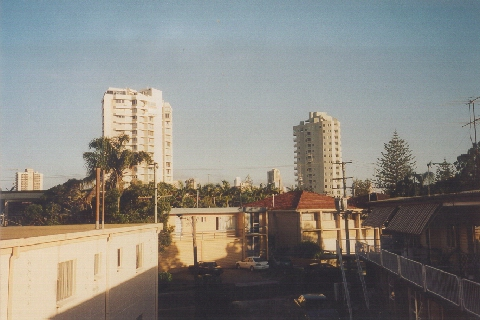

In [54]:
# random pick a image and show
n_im = np.random.random_integers(num_im)-1
imname = test_imlist[n_im]
print 'Image path: '+img_dir+imname+'.jpg'
IPython.display.Image(filename=img_dir+imname+'.jpg') 

In [55]:
# Load feature
context_features = load_feature.load_context_feature(cached_context_features_dir,imname)
context_features = np.repeat(context_features,100,axis=0)
imcrop_names = imcrop_dict[imname]
candidate_boxes = candidate_boxes_dict[imname]
num_imcrop = len(imcrop_names)
num_proposal = candidate_boxes.shape[0]

local = np.load(local_context_features_dir+imname+'.npz')
local_feature = local['local_feature']
spatial_feats = local['spatial_feat']

Total proposals = 100


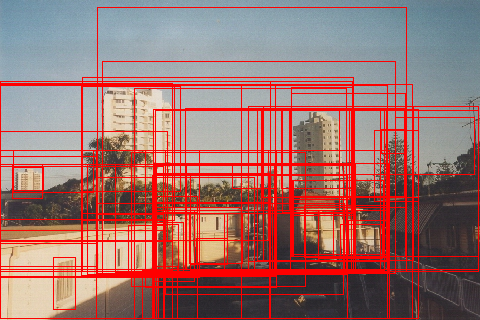

In [56]:
# show candidates bounding box
from PIL import Image, ImageDraw, ImageFont
im = Image.open(img_dir + imname + '.jpg')
dr = ImageDraw.Draw(im)
for box in candidate_boxes:
    dr.rectangle(((box[0],box[1]),(box[2],box[3])), outline = "red")
print 'Total proposals =', len(candidate_boxes)
im.save("candidates.png")
IPython.display.Image("candidates.png")

In [57]:
print 'Query:'
count = 1
for n_imcrop in range(num_imcrop):
    imcrop_name = imcrop_names[n_imcrop]
    gt_bbox = np.array(imcrop_bbox_dict[imcrop_name])
    for n_sentence in range(len(query_dict[imcrop_name])):
        sentence = query_dict[imcrop_name][n_sentence]
        print count, sentence
        count = count+1

Query:
1 tower
2 building bottom left
3 sky
4 tallest bldng


In [62]:
# query '???'
query = 'left tower'
query = np.tile(query, len(candidate_boxes))
current_query_ind = map(lambda cap: [vocab_dict[word] for word in cap.lower().split(' ') if word in vocab_dict], query)
current_query_matrix = sequence.pad_sequences(current_query_ind, padding='post', maxlen=MAX_QUERY_WORDS-1)
current_query_matrix = np.hstack( [current_query_matrix, np.zeros( [len(current_query_matrix),1]) ] ).astype(int)
current_query_mask = np.zeros((current_query_matrix.shape[0], current_query_matrix.shape[1]))
nonzeros = np.array( map(lambda x: (x != 0).sum()+1, current_query_matrix ))
for ind, row in enumerate(current_query_mask):
    row[0:nonzeros[ind]] = 1
scores = sess.run([tf_score],
        feed_dict={
            tf_local_image: local_feature,
            tf_image: context_features,
            tf_query: current_query_matrix,
            tf_query_mask: current_query_mask,
            tf_bbox: spatial_feats
        })
topK_ids = np.argsort(-scores[0][0])[:5]
print topK_ids

[22 93  7 75 18]


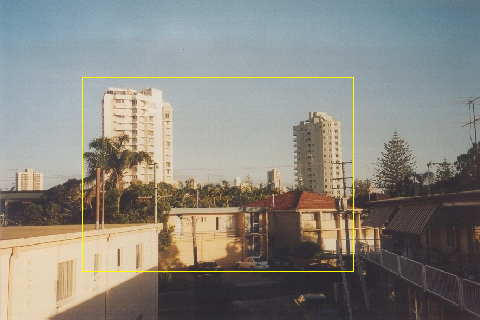

In [63]:
topK_ids = np.argsort(-scores[0][0])[:1]
im = Image.open(img_dir + imname + '.jpg')
dr = ImageDraw.Draw(im)
for box in candidate_boxes[topK_ids]:
    dr.rectangle(((box[0],box[1]),(box[2],box[3])), outline = "yellow")
im.save("results.png")
IPython.display.Image("results.png")